Import.

In [22]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Load.

In [2]:
df = pd.read_csv(r"..\data\datasets\winequality-red.csv")
df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Split fitur-target.

In [3]:
X = df.drop(columns="quality")
y = df["quality"]

Binning karena imbalance. Bade (2,3), Average (4,5), dan Good (6,8).

In [4]:
y = pd.cut(y, bins=[2, 4, 6, 8], labels=['Bad', 'Average', 'Good'], include_lowest=True)

Missing values handling.

In [7]:
X.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Dupicate handling.

In [8]:
X.duplicated().sum()

np.int64(240)

In [5]:
X = X.drop_duplicates()
y = y.loc[X.index]

Split train-test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Outlier handling.

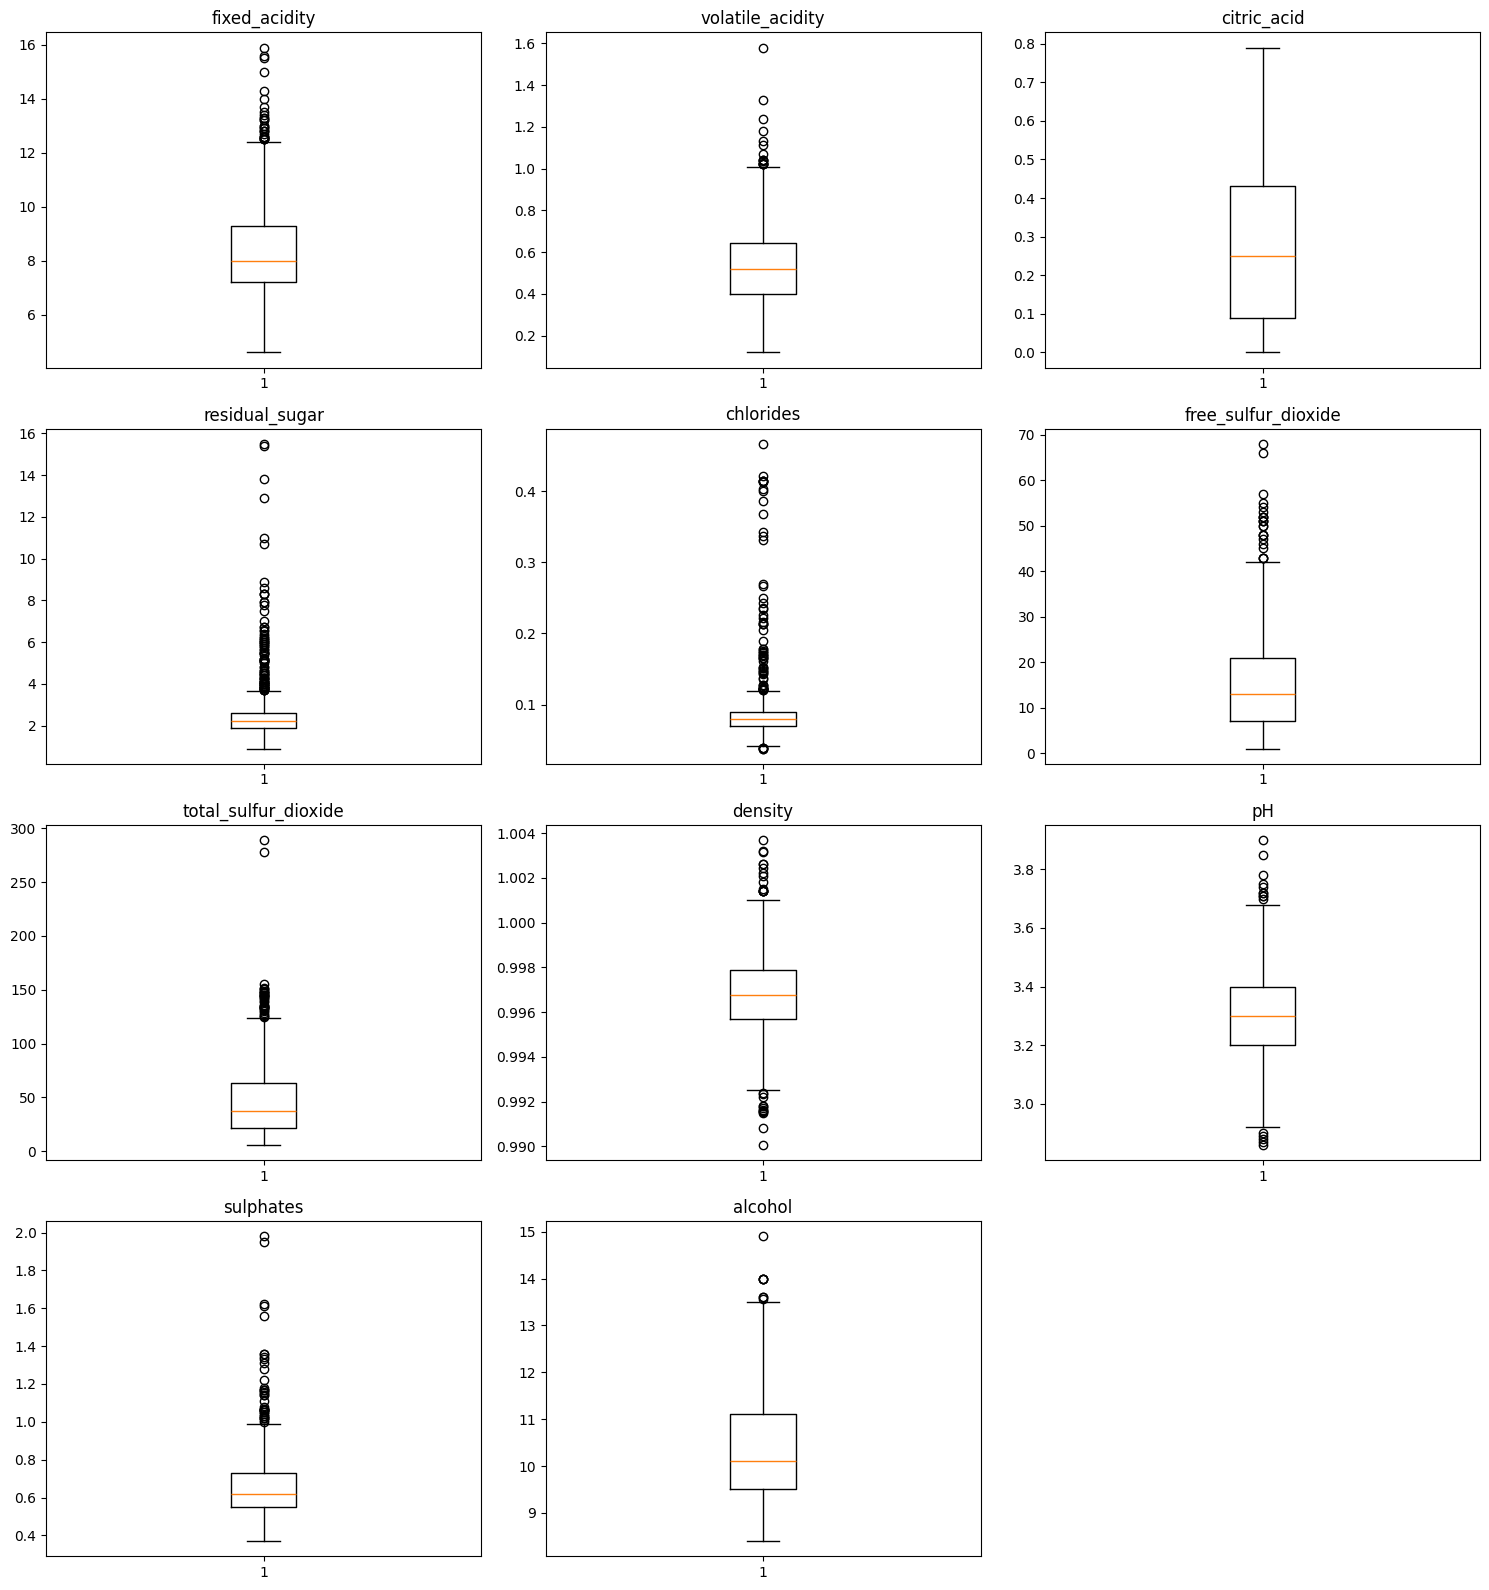

In [16]:
n_cols = 3
n_rows = math.ceil(len(X_train.columns)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()
for ax, col in zip(axes, X_train.columns):
    ax.boxplot(X_train[col])
    ax.set_title(col)
for ax in axes[len(X_train.columns):]:
    ax.remove()
plt.tight_layout()
plt.show()

In [17]:
def filter_outliers(df):
    mask = (
        (df['fixed_acidity'] <= 14) &
        (df['volatile_acidity'] <= 1.2) &
        (df['residual_sugar'] <= 10) &
        (df['chlorides'] <= 0.5) &
        (df['free_sulfur_dioxide'] <= 60) &
        (df['total_sulfur_dioxide'] <= 200) &
        (df['pH'] <= 3.8) &
        (df['sulphates'] <= 1.50) &
        (df['alcohol'] <= 14)
    )
    return df[mask]

X_train = filter_outliers(X_train)
y_train = y_train.loc[X_train.index]

Normalisasi distribusi.

In [18]:
# Tidak perlu.

Training.

In [19]:
model = Pipeline([
    ('smote', SMOTE(random_state=42)),  
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

,steps,"[('smote', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


Evaluasi.

In [20]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Average       0.88      0.86      0.87       334
         Bad       0.30      0.16      0.21        19
        Good       0.43      0.58      0.50        55

    accuracy                           0.79       408
   macro avg       0.54      0.53      0.52       408
weighted avg       0.79      0.79      0.79       408



Hyperparameter tuning.

In [31]:
param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],        # jumlah pohon
    'classifier__max_depth': [None, 5, 10, 20, 30, 50],     # kedalaman pohon
    'classifier__min_samples_split': randint(2, 20),        # minimum split node
    'classifier__min_samples_leaf': randint(1, 10),         # minimum leaf
    'classifier__max_features': ['sqrt', 'log2', None],     # fitur per pohon
    'classifier__bootstrap': [True, False],                 # sampling metode
    'classifier__criterion': ['gini', 'entropy'],           # fungsi impurity
}

random_search = RandomizedSearchCV(
    estimator=model,         
    param_distributions=param_dist,
    n_iter=300,
    cv=4,                       
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'classifier__bootstrap': [True, False], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [None, 5, ...], 'classifier__max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,300
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [32]:
random_search.best_params_

{'classifier__bootstrap': False,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 30,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50}

In [33]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Average       0.90      0.80      0.85       334
         Bad       0.29      0.26      0.28        19
        Good       0.41      0.71      0.52        55

    accuracy                           0.76       408
   macro avg       0.54      0.59      0.55       408
weighted avg       0.81      0.76      0.78       408



Confussion matrix.

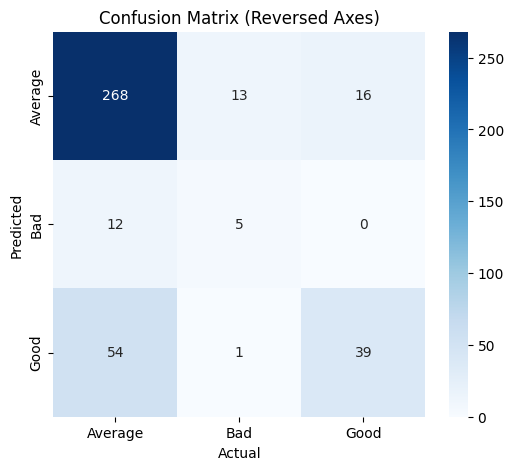

In [34]:
labels = ["Average", "Bad", "Good"]
rf = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(rf.T, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix (Reversed Axes)')
plt.show()

Feature importance.

In [35]:
feat_importance = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.named_steps['classifier'].feature_importances_})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
print(feat_importance)

                 feature  importance
10               alcohol    0.167147
9              sulphates    0.164288
1       volatile_acidity    0.151886
6   total_sulfur_dioxide    0.097072
2            citric_acid    0.074302
8                     pH    0.070948
5    free_sulfur_dioxide    0.064922
0          fixed_acidity    0.058600
4              chlorides    0.052136
3         residual_sugar    0.050675
7                density    0.048024


Export model.

In [36]:
with open(r'..\models\rf_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [41]:
# EOL